In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Measured Atomic Spectral Lines
<table>
  <tr>
    <td><img src="Hg_Spectrum.jpeg" width="300"></td>
    <td><img src="He_Spectrum.jpeg" width="300"></td>
  </tr>
</table>

In [2]:
def vectorized_universal(func):
    """
    Wraps a NumPy function that expects ndarrays, allowing it to take
    Series, lists, ndarrays, or scalars — including Series of arrays/lists.
    Returns the same type as the first argument.
    """
    def wrapper(*args):
        first_arg = args[0]
        primary_type = type(first_arg)

        processed_args = []
        for arg in args:
            # Case 1: pandas Series
            if isinstance(arg, pd.Series):
                first_val = arg.iloc[0]
                if isinstance(first_val, (np.ndarray, list)):
                    arr = np.stack(arg.values)
                else:
                    arr = arg.to_numpy()
            
            # Case 2: plain list
            elif isinstance(arg, list):
                if len(arg) > 0 and isinstance(arg[0], (np.ndarray, list)):
                    arr = np.stack(arg)
                else:
                    arr = np.array(arg)
            
            # Case 3: ndarray
            elif isinstance(arg, np.ndarray):
                arr = arg
            
            # ✅ Case 4: scalar (float, int, numpy scalar)
            elif np.isscalar(arg):
                arr = np.array(arg)
            
            else:
                raise TypeError(f"Unsupported argument type: {type(arg)}")
            
            processed_args.append(arr)

        # Call original NumPy function
        result = func(*processed_args)

        # Return in same type as first argument
        if isinstance(result, np.ndarray):
            if issubclass(primary_type, pd.Series):
                # Handle 2D result → Series of arrays
                if result.ndim > 1:
                    return pd.Series([row for row in result], index=first_arg.index)
                else:
                    return pd.Series(result, index=first_arg.index)
            elif primary_type is list:
                return result.tolist()
            else:
                return result  # ndarray input → ndarray output
        else:
            # If result is scalar or other type
            if issubclass(primary_type, pd.Series):
                return pd.Series([result] * len(first_arg), index=first_arg.index)
            elif primary_type is list:
                return [result] * len(first_arg)
            else:
                return result

    return wrapper

### Helper Fuctions

In [3]:
line_wavelengths = {
    "Hg-V": 435.83,
    "Hg-G": 546.07,
    "Hg-Y": (576.96+579.06)/2,
    "He-V": 447.15,
    "He-G": 501.57,
    "He-Y": 587.56,
    "He-RI": 667.82,
    "He-RII": 706.52
}

def dms_to_sec(dms):
    if dms.shape[-1] != 3:
        raise ValueError("dms must have exactly 3 entries")
    dms = dms.transpose()
    return (dms[0]*3600 + dms[1]*60 + dms[2]).transpose()

def sec_to_dms(sec):
    sec = sec.astype(int).transpose()
    min = sec // 60
    sec = sec % 60  
    deg = min // 60
    min = min % 60
    return np.array([deg, min, sec]).transpose()

def dms_to_deg(dms):
    return dms_to_sec(dms)/3600

def deg_to_dms(deg):
    return sec_to_dms(deg*3600)

def dms_redistribute(dms):
    return sec_to_dms(dms_to_sec(dms))

def combine_vs_reading(msr, vsd, vc=20):
    return sec_to_dms(dms_to_sec(msr) + vsd*vc)

# Wrap for compatibility with dataframe colums
dms_to_sec = vectorized_universal(dms_to_sec)
sec_to_dms = vectorized_universal(sec_to_dms)
dms_to_deg = vectorized_universal(dms_to_deg)
deg_to_dms = vectorized_universal(deg_to_dms)
dms_redistribute = vectorized_universal(dms_redistribute)
combine_vs_reading = vectorized_universal(combine_vs_reading) 

### Direct Reading

In [4]:
# Data for direct reading

direct_data = pd.DataFrame({
    "MSR": [np.array(x) for x in [[82, 40, 0], [262-180, 40, 0],
    [82, 40, 0], [262-180, 40, 0],
    [82, 20, 0], [262-180, 40, 0],
    [82, 40, 0], [262-180, 40, 0],
    [262-180, 40, 0], [82, 40, 0],
    [262-180, 40, 0], [82, 40, 0]]],
    "VSD": [2, 6, 1, 15, 56, 4, 1, 5, 27, 17, 22, 17]
})

direct_data["Angle"] = combine_vs_reading(direct_data["MSR"], direct_data["VSD"])
direct_data["Angle (deg)"] = dms_to_deg(direct_data["Angle"])

direct_angle = direct_data["Angle (deg)"].mean()
direct_angle_err = direct_data["Angle (deg)"].sem()

print(f'Direct Angle = ({direct_angle:.2f} ± {direct_angle_err:.3f}) deg')
display(direct_data)

Direct Angle = (82.72 ± 0.016) deg


,MSR,VSD,Angle,Angle (deg)
0,"[82, 40, 0]",2,"[82, 40, 40]",82.677778
1,"[82, 40, 0]",6,"[82, 42, 0]",82.700000
2,"[82, 40, 0]",1,"[82, 40, 20]",82.672222
3,"[82, 40, 0]",15,"[82, 45, 0]",82.750000
4,"[82, 20, 0]",56,"[82, 38, 40]",82.644444
5,"[82, 40, 0]",4,"[82, 41, 20]",82.688889
6,"[82, 40, 0]",1,"[82, 40, 20]",82.672222
7,"[82, 40, 0]",5,"[82, 41, 40]",82.694444
8,"[82, 40, 0]",27,"[82, 49, 0]",82.816667
9,"[82, 40, 0]",17,"[82, 45, 40]",82.761111


### Readings for Side AB

In [5]:
msr_readings = [
    [41, 0, 0], [41, 0, 0], [41, 0, 0], [41, 0, 0],
    [41, 20, 0], [41, 20, 0], [41, 20, 0], [41, 20, 0],
    [41, 40, 0], [41, 40, 0], [41, 40, 0], [41, 40, 0],
    [42, 0, 0], [42, 0, 0], [42, 0, 0], [42, 0, 0],
    [42, 0, 0], [42, 0, 0], [42, 0, 0], [42, 0, 0],
    [40, 40, 0], [40, 40, 0], [40, 40, 0], [40, 40, 0],
    [41, 20, 0], [41, 20, 0], [41, 20, 0], [41, 20, 0],
    [41, 40, 0], [41, 40, 0], [41, 40, 0], [41, 40, 0]
]

vsr_readings = [
    18, 10, 15, 12, 25, 20, 23, 28, 33, 35, 35, 33, 
    21, 20, 27, 17, 39, 39, 44, 38, 43, 24, 24, 38,
    39, 55, 39, 52, 3, 15, 17, 3
]

# Other columns data (wavelengths and vsd remain unchanged)
data = {
    'line': [
        'He-V', 'He-V', 'He-V', 'He-V', 'He-G', 'He-G', 'He-G', 'He-G', 
        'He-Y', 'He-Y', 'He-Y', 'He-Y', 'He-RI', 'He-RI', 'He-RI', 'He-RI', 
        'He-RII', 'He-RII', 'He-RII', 'He-RII', 'Hg-V', 'Hg-V', 'Hg-V', 'Hg-V', 
        'Hg-G', 'Hg-G', 'Hg-G', 'Hg-G', 'Hg-Y', 'Hg-Y', 'Hg-Y', 'Hg-Y'
    ],
    'wavelength': [
        447.15, 447.15, 447.15, 447.15, 501.57, 501.57, 501.57, 501.57, 
        587.56, 587.56, 587.56, 587.56, 667.82, 667.82, 667.82, 667.82, 
        706.52, 706.52, 706.52, 706.52, 435.83, 435.83, 435.83, 435.83, 
        546.07, 546.07, 546.07, 546.07, 578.01, 578.01, 578.01, 578.01
    ],
    'MSR': msr_readings, # This column holds the corrected and processed NumPy arrays
    'VSD': vsr_readings
}


# --- 2. Create DataFrame --
data_AB = pd.DataFrame(data)
data_AB['Angle'] = combine_vs_reading(data_AB['MSR'], data_AB['VSD'])
data_AB['Angle (deg)'] = dms_to_deg(data_AB['Angle'])

# Define the aggregation functions
aggregation_functions = {
    'wavelength': 'first',
    'Angle (deg)': ['mean', 'sem']         
}

# Group the data and apply the functions
summary_AB = data_AB.groupby('line', sort = False).agg(aggregation_functions).reset_index()

# Flatten the multi-level column names for a cleaner result
summary_AB.columns = ['line', 'wavelength', 'angle_mean', 'angle_sem']


display(data_AB)
display(summary_AB)

,line,wavelength,MSR,VSD,Angle,Angle (deg)
0,He-V,447.15,"[41, 0, 0]",18,"[41, 6, 0]",41.100000
1,He-V,447.15,"[41, 0, 0]",10,"[41, 3, 20]",41.055556
2,He-V,447.15,"[41, 0, 0]",15,"[41, 5, 0]",41.083333
3,He-V,447.15,"[41, 0, 0]",12,"[41, 4, 0]",41.066667
4,He-G,501.57,"[41, 20, 0]",25,"[41, 28, 20]",41.472222
5,He-G,501.57,"[41, 20, 0]",20,"[41, 26, 40]",41.444444
6,He-G,501.57,"[41, 20, 0]",23,"[41, 27, 40]",41.461111
7,He-G,501.57,"[41, 20, 0]",28,"[41, 29, 20]",41.488889
8,He-Y,587.56,"[41, 40, 0]",33,"[41, 51, 0]",41.850000
9,He-Y,587.56,"[41, 40, 0]",35,"[41, 51, 40]",41.861111


,line,wavelength,angle_mean,angle_sem
0,He-V,447.15,41.076389,0.009722
1,He-G,501.57,41.466667,0.009351
2,He-Y,587.56,41.855556,0.003208
3,He-RI,667.82,42.118056,0.011648
4,He-RII,706.52,42.222222,0.007522
5,Hg-V,435.83,40.845833,0.027063
6,Hg-G,546.07,41.590278,0.023502
7,Hg-Y,578.01,41.719444,0.020972


### Readings for Side AC

In [6]:
msr_readings = [
    # He Violet
    [124, 20, 0], [124, 20, 0], [124, 20, 0], [124, 20, 0],
    # He Green
    [124, 0, 0], [124, 0, 0], [124, 0, 0], [124, 0, 0],
    # He Yellow
    [123, 40, 0], [123, 40, 0], [123, 40, 0], [123, 40, 0],
    # He Red I
    [123, 20, 0], [123, 20, 0], [123, 20, 0], [123, 20, 0],
    # He Red II
    [123, 20, 0], [123, 20, 0], [123, 20, 0], [123, 20, 0],
    # Hg Violet
    [124, 20, 0], [124, 20, 0], [124, 20, 0], [124, 20, 0],
    # Hg Green
    [123, 40, 0], [123, 40, 0], [123, 40, 0], [123, 40, 0],
    # Hg Yellow
    [123, 40, 0], [123, 20, 0], [123, 40, 0], [123, 20, 0]
]

vsr_readings = [
    # He Violet
    54, 48, 51, 46,
    # He Green
    32, 36, 30, 27,
    # He Yellow
    10, 7, 9, 8,
    # He Red I
    23, 26, 23, 26,
    # He Red II
    3, 6, 3, 4,
    # Hg Violet
    35, 25, 32, 25,
    # Hg Green
    8, 15, 19, 9,
    # Hg Yellow
    0, 50, 0, 51
]

# Other columns data (wavelengths and vsd remain unchanged)
data = {
    'line': [
        'He-V', 'He-V', 'He-V', 'He-V', 'He-G', 'He-G', 'He-G', 'He-G', 
        'He-Y', 'He-Y', 'He-Y', 'He-Y', 'He-RI', 'He-RI', 'He-RI', 'He-RI', 
        'He-RII', 'He-RII', 'He-RII', 'He-RII', 'Hg-V', 'Hg-V', 'Hg-V', 'Hg-V', 
        'Hg-G', 'Hg-G', 'Hg-G', 'Hg-G', 'Hg-Y', 'Hg-Y', 'Hg-Y', 'Hg-Y'
    ],
    'wavelength': [
        447.15, 447.15, 447.15, 447.15, 501.57, 501.57, 501.57, 501.57, 
        587.56, 587.56, 587.56, 587.56, 667.82, 667.82, 667.82, 667.82, 
        706.52, 706.52, 706.52, 706.52, 435.83, 435.83, 435.83, 435.83, 
        546.07, 546.07, 546.07, 546.07, 578.01, 578.01, 578.01, 578.01
    ],
    'MSR': msr_readings, # This column holds the corrected and processed NumPy arrays
    'VSD': vsr_readings
}


# --- 2. Create DataFrame --
data_AC = pd.DataFrame(data)
data_AC['Angle'] = combine_vs_reading(data_AC['MSR'], data_AC['VSD'])
data_AC['Angle (deg)'] = dms_to_deg(data_AC['Angle'])

# Define the aggregation functions
aggregation_functions = {
    'wavelength': 'first',
    'Angle (deg)': ['mean', 'sem']         
}

# Group the data and apply the functions
summary_AC = data_AC.groupby('line', sort = False).agg(aggregation_functions).reset_index()

# Flatten the multi-level column names for a cleaner result
summary_AC.columns = ['line', 'wavelength', 'angle_mean', 'angle_sem']


display(data_AC)
display(summary_AC)

,line,wavelength,MSR,VSD,Angle,Angle (deg)
0,He-V,447.15,"[124, 20, 0]",54,"[124, 38, 0]",124.633333
1,He-V,447.15,"[124, 20, 0]",48,"[124, 36, 0]",124.600000
2,He-V,447.15,"[124, 20, 0]",51,"[124, 37, 0]",124.616667
3,He-V,447.15,"[124, 20, 0]",46,"[124, 35, 20]",124.588889
4,He-G,501.57,"[124, 0, 0]",32,"[124, 10, 40]",124.177778
5,He-G,501.57,"[124, 0, 0]",36,"[124, 12, 0]",124.200000
6,He-G,501.57,"[124, 0, 0]",30,"[124, 10, 0]",124.166667
7,He-G,501.57,"[124, 0, 0]",27,"[124, 9, 0]",124.150000
8,He-Y,587.56,"[123, 40, 0]",10,"[123, 43, 20]",123.722222
9,He-Y,587.56,"[123, 40, 0]",7,"[123, 42, 20]",123.705556


,line,wavelength,angle_mean,angle_sem
0,He-V,447.15,124.609722,0.009722
1,He-G,501.57,124.173611,0.010486
2,He-Y,587.56,123.713889,0.003586
3,He-RI,667.82,123.469444,0.004811
4,He-RII,706.52,123.355556,0.003928
5,Hg-V,435.83,124.495833,0.014050
6,Hg-G,546.07,123.737500,0.014411
7,Hg-Y,578.01,123.640278,0.015278


### Minimum Deviation Angles

In [7]:
# Angles of mininum deviation
min_deviation = pd.DataFrame({
    'Line': summary_AB['line'],
    'Wavelength': summary_AB['wavelength'],
    'Angle_AB': direct_angle - summary_AB['angle_mean'],
    'Angle_AB_Err': np.sqrt(summary_AB['angle_sem']**2 + direct_angle_err**2),
    'Angle_AC': summary_AC['angle_mean'] - direct_angle,
    'Angle_AC_Err': np.sqrt(summary_AC['angle_sem']**2 + direct_angle_err**2),
})

min_deviation['angle'] = (min_deviation['Angle_AB']/(min_deviation['Angle_AB_Err']**2) + 
                         min_deviation['Angle_AC']/(min_deviation['Angle_AC_Err']**2))/(
                         1/min_deviation['Angle_AB_Err']**2 + 1/min_deviation['Angle_AC_Err']**2)

min_deviation['angle_err'] = (1/min_deviation['Angle_AB_Err']**2 + 1/min_deviation['Angle_AC_Err']**2)**(-0.5)


display(min_deviation)
min_deviation.sort_values(by='Wavelength', inplace=True)

,Line,Wavelength,Angle_AB,Angle_AB_Err,Angle_AC,Angle_AC_Err,angle,angle_err
0,He-V,447.15,41.642593,0.018446,41.890741,0.018446,41.766667,0.013043
1,He-G,501.57,41.252315,0.018253,41.454630,0.018859,41.350167,0.013116
2,He-Y,587.56,40.863426,0.016000,40.994907,0.016081,40.928838,0.011342
3,He-RI,667.82,40.600926,0.019529,40.750463,0.016397,40.688633,0.012558
4,He-RII,706.52,40.496759,0.017387,40.636574,0.016160,40.571772,0.011837
5,Hg-V,435.83,41.873148,0.031275,41.776852,0.021051,41.806876,0.017463
6,Hg-G,546.07,41.128704,0.028250,41.018519,0.021294,41.058439,0.017004
7,Hg-Y,578.01,40.999537,0.026183,40.921296,0.021889,40.953484,0.016794


### Refractive Indices 

In [8]:
# Apex Angle Readings from O1
apex_angle = 62.69
apex_angle_err = 0.05

index_data = pd.DataFrame({
    'Line': min_deviation['Line'],
    'Wavelength': min_deviation['Wavelength'],
    'n_AB': np.sin(np.deg2rad((min_deviation['Angle_AB']+apex_angle)/2))/np.sin(np.deg2rad(apex_angle/2)),
    'n_AC': np.sin(np.deg2rad((min_deviation['Angle_AC']+apex_angle)/2))/np.sin(np.deg2rad(apex_angle/2)),
    'n': np.sin(np.deg2rad((min_deviation['angle']+apex_angle)/2))/np.sin(np.deg2rad(apex_angle/2))
})

index_data

,Line,Wavelength,n_AB,n_AC,n
5,Hg-V,435.83,1.520650,1.519661,1.519969
0,He-V,447.15,1.518280,1.520830,1.519556
1,He-G,501.57,1.514256,1.516344,1.515266
6,Hg-G,546.07,1.512977,1.511836,1.512250
7,Hg-Y,578.01,1.511640,1.510828,1.511162
2,He-Y,587.56,1.510228,1.511592,1.510907
3,He-RI,667.82,1.507499,1.509055,1.508412
4,He-RII,706.52,1.506414,1.507870,1.507196


## Curve Fitting

Fitted coefficients:
A = 1.499469 ± 0.001271
B = 0.003874 ± 0.000743
C = 0.000015 ± 0.000100
[[ 1.61600212e-06 -9.32835742e-07  1.22686586e-07]
 [-9.32835742e-07  5.51501835e-07 -7.37542844e-08]
 [ 1.22686586e-07 -7.37542844e-08  1.00190083e-08]]


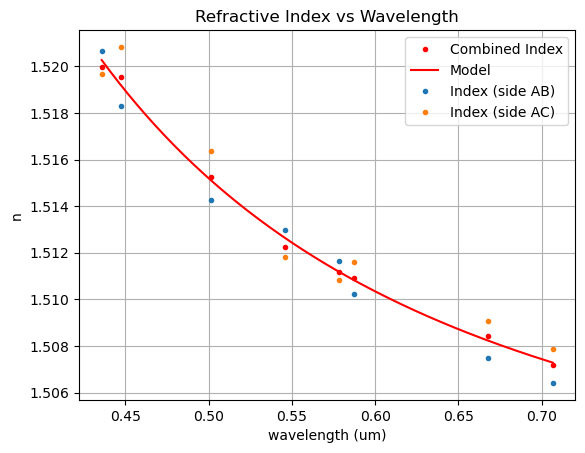

In [9]:
x = index_data['Wavelength'].to_numpy()/1000
y = index_data['n'].to_numpy()
y1 = index_data['n_AB'].to_numpy()
y2 = index_data['n_AC'].to_numpy()

def cauchy(lam, A, B, C):
    return A + B / lam**2 + C / lam**4

# Fit the data
popt, pcov = curve_fit(cauchy, x, y)
perr = np.sqrt(np.diag(pcov))

A, B, C = popt
A_err, B_err, C_err = perr

print(f"Fitted coefficients:")
print(f"A = {A:.6f} ± {A_err:.6f}")
print(f"B = {B:.6f} ± {B_err:.6f}")
print(f"C = {C:.6f} ± {C_err:.6f}")

print(pcov)
# Generate smooth curve for plotting
x_fit = np.linspace(np.min(x), np.max(x), 200)
y_fit = cauchy(x_fit, *popt)


# Plot with error bars
plt.errorbar(x, y,  label='Combined Index',   fmt='.', color='red')
plt.errorbar(x_fit, y_fit,  label='Model',   fmt='-', color='red')
plt.errorbar(x, y1, label='Index (side AB)',   fmt='.')
plt.errorbar(x, y2, label='Index (side AC)', fmt='.')

plt.legend()
plt.xlabel('wavelength (um)')
plt.ylabel('n')
plt.title('Refractive Index vs Wavelength')
plt.grid(True)
plt.show()

Fitted coefficients:
A = 1.499291 ± 0.000308
B = 0.003981 ± 0.000085
[[ 9.51158069e-08 -2.48433093e-08]
 [-2.48433093e-08  7.16721952e-09]]


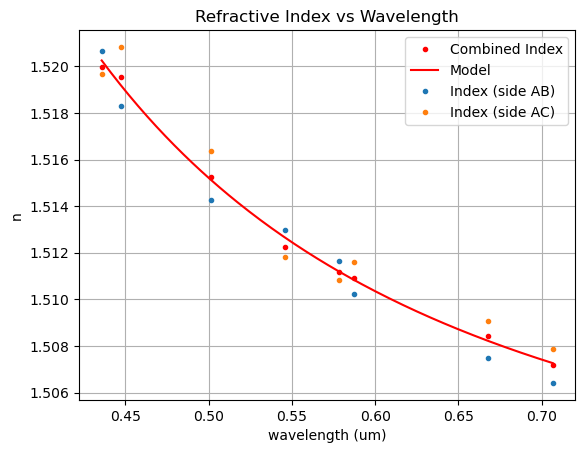

In [10]:
def cauchy(lam, A, B):
    return A + B / lam**2

# Fit the data
popt, pcov = curve_fit(cauchy, x, y)
perr = np.sqrt(np.diag(pcov))

A, B = popt
A_err, B_err = perr

print(f"Fitted coefficients:")
print(f"A = {A:.6f} ± {A_err:.6f}")
print(f"B = {B:.6f} ± {B_err:.6f}")

print(pcov)
# Generate smooth curve for plotting
x_fit = np.linspace(np.min(x), np.max(x), 200)
y_fit = cauchy(x_fit, *popt)


# Plot with error bars
plt.errorbar(x, y,  label='Combined Index',   fmt='.', color='red')
plt.errorbar(x_fit, y_fit,  label='Model',   fmt='-', color='red')
plt.errorbar(x, y1, label='Index (side AB)',   fmt='.')
plt.errorbar(x, y2, label='Index (side AC)', fmt='.')

plt.legend()
plt.xlabel('wavelength (um)')
plt.ylabel('n')
plt.title('Refractive Index vs Wavelength')
plt.grid(True)
plt.show()